In [1]:
#%pip install pandas
#%pip install scikit-learn

In [2]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import os
import random

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
print(tf.__version__)

2.2.0


In [5]:
%pip install -U tensorboard_plugin_profile

     |████████████████████████████████| 1.1 MB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [7]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [8]:
#%tensorboard --logdir logs/fit
%tensorboard --logdir ./logs --host 0.0.0.0
#!kill 200

In [9]:
#%reload_ext tensorboard

In [10]:
#path = '../dataset/gemini_BTCUSD_2019_1min.csv'
path = '../../dataset/gemini_BTCUSD_2019_1min.csv'
# Skipping the first line of the csv-file
with open(path, 'r') as f:
    next(f)
    df = pd.read_csv(f, parse_dates = ['Date'])#, index_col = 'Date')

print(df.head())
print(len(df.index))

   Unix Timestamp                Date  Symbol     Open     High      Low  \
0   1592352000000 2020-06-17 00:00:00  BTCUSD  9526.40  9539.67  9526.40   
1   1592351940000 2020-06-16 23:59:00  BTCUSD  9525.68  9532.30  9525.68   
2   1592351880000 2020-06-16 23:58:00  BTCUSD  9521.38  9531.92  9521.38   
3   1592351820000 2020-06-16 23:57:00  BTCUSD  9525.20  9526.45  9521.27   
4   1592351760000 2020-06-16 23:56:00  BTCUSD  9522.95  9525.20  9518.31   

     Close    Volume  
0  9533.36  0.020150  
1  9526.40  0.006691  
2  9525.68  0.049345  
3  9521.38  0.292681  
4  9525.20  3.621439  
712796


In [11]:
df = df[['Date', 'Open', 'Volume']]
print(df.dtypes)

Date      datetime64[ns]
Open             float64
Volume           float64
dtype: object


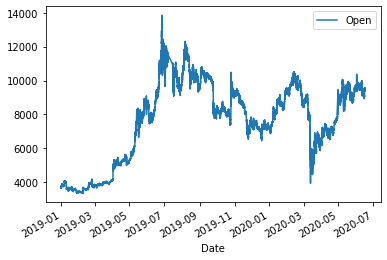

In [12]:
df.plot(x = 'Date', y = 'Open')

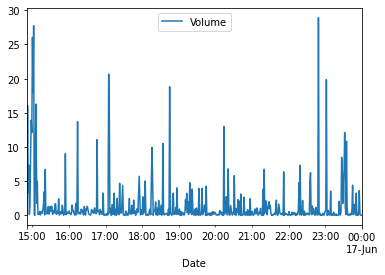

In [13]:
df.iloc[:550].plot(x = 'Date', y = 'Volume')

In [14]:
# Converting to percentage change between the current and prior element
print(df.head())
#df[['Open', 'Volume']] = df[['Open', 'Volume']].pct_change()
df['Open'] = df['Open'].pct_change()
df = df.drop(index = 0) # Drop the first row since it is NaN due to pct_change()
print(df.head())

                 Date     Open    Volume
0 2020-06-17 00:00:00  9526.40  0.020150
1 2020-06-16 23:59:00  9525.68  0.006691
2 2020-06-16 23:58:00  9521.38  0.049345
3 2020-06-16 23:57:00  9525.20  0.292681
4 2020-06-16 23:56:00  9522.95  3.621439
                 Date      Open    Volume
1 2020-06-16 23:59:00 -0.000076  0.006691
2 2020-06-16 23:58:00 -0.000451  0.049345
3 2020-06-16 23:57:00  0.000401  0.292681
4 2020-06-16 23:56:00 -0.000236  3.621439
5 2020-06-16 23:55:00 -0.000003  0.064634


In [15]:
# Converting to a numpy-array, dropping the 'Date'-column and standardizing
df = df[['Open', 'Volume']].to_numpy()
df = (df-df.mean(axis=0))/df.std(axis=0)
print(type(df), df.shape, df[0])

<class 'numpy.ndarray'> (712795, 2) [-0.06260313 -0.18780868]


In [16]:
#df = df[:1000]
#print(df.shape)
#print(df[:10])

In [17]:
# Converting the dataset (numpy-array) to a numpy-array which fits the model
# The first dimension represents the number of examples
# The second dimension represents the length of the time series used to make a prediction
# The third dimension represents the number of features used (e.g. 'Open', 'Volume' etc)

# future_pred = 0 means that we are predicting only one time step in the future
# seq_len represents the length of the time series used to make a prediction
def to_sequences(dataset, seq_len, future_pred):
    
    features = []
    labels = []
    
    i = 0
    #label = dataset[seq_len+future_pred, :]

    while i+seq_len+future_pred < len(dataset):
        feature = dataset[i:i+seq_len, :]
        features.append(feature)
        
        label = dataset[i+seq_len+future_pred, 0]
        labels.append(label)
        
        i += 1
        
    return np.array(features), np.array(labels)
    

In [18]:
#features, labels = to_sequences(dataset = df, seq_len = 3, future_pred = 0)
#print(features.shape, '\n', features)
#print(labels.shape, '\n', labels)

In [19]:
### Use subset of dataset for testing purposes ###
#print(df.shape)
#df = df[:1000]
#print(df.shape)

In [20]:
### Generating the training, validation and testing datasets ###
# The training and validation sets are completely separated from the test set, in that the latter consists of
# the 'isolated' last test_size-part of the dataset.
# The training and validation sets are intertwined in that they are randomly generated using 
# train_test_split from sklearn

train_size = 0.8
val_size = 0.1
test_size = 1 - (train_size + val_size)
seq_len = 50
future_pred = 0

df_train, df_test = df[0:int((train_size+val_size)*len(df))], df[int((train_size+val_size)*len(df)):]

x_train, y_train = to_sequences(dataset = df_train, 
                                seq_len = seq_len, 
                                future_pred = future_pred)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size/(train_size+val_size))

x_test, y_test = to_sequences(dataset = df_test, 
                              seq_len = seq_len, 
                              future_pred = future_pred)

In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)
#tot = len(x_train)+len(x_val)+len(x_test)
#print(tot, len(df))

(570191, 50, 2)
(570191,)
(71274, 50, 2)
(71274,)
(71230, 50, 2)
(71230,)


(array([2.00000e+00, 0.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00,
        4.00000e+00, 1.00000e+00, 3.00000e+00, 5.00000e+00, 1.20000e+01,
        2.20000e+01, 5.60000e+01, 1.79000e+02, 1.02400e+03, 5.39760e+04,
        5.11491e+05, 2.76900e+03, 4.24000e+02, 1.14000e+02, 6.00000e+01,
        2.00000e+01, 1.00000e+01, 4.00000e+00, 4.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-64.62746907, -60.36855109, -56.10963311, -51.85071513,
        -47.59179715, -43.33287917, -39.07396119, -34.81504321,
        -30.55612523, -26.29720725, -22.03828927, -17.77937129,
        -13.52045332,  -9.26153534,  -5.00261736,  -0.74369938,
          3.5152186 ,   7.77413658,  12.03305456,  16.29197254,
         20.55089052,  24.8098085 ,  29.06872648,  33.32764446,
         37.58656244,  41.84548042,  46.1043984 ,  50.36331638,
         54.62223436,  58.88115234,  63.14007032]),
 <a list of 30 Patch objects>)

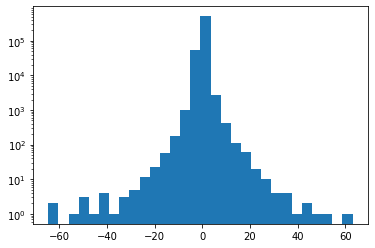

In [22]:
plt.hist(y_train, bins = 30, log = True)

In [23]:
### Oversampling ###
a = y_train[:10]
print('a = ', a)
p = np.abs(a) / np.sum(np.abs(a))
print('p = ', p, np.sum(p))
r = np.random.choice(list(range(len(a))), size = 3, replace = True, p = p)
print('r = ', r)
b = a[r]
print('b = ', b)
a = np.append(a, a[r])
print('a = ', a)

a =  [ 5.11760372e-04  1.57461465e+00 -4.07178456e-04  3.11532252e-01
 -6.39540744e-04  7.02540980e-01  3.11526488e-03  5.11760372e-04
 -3.11516160e-02  5.11760372e-04]
p =  [1.94916475e-04 5.99730567e-01 1.55083890e-04 1.18654690e-01
 2.43584760e-04 2.67579944e-01 1.18652495e-03 1.94916475e-04
 1.18648561e-02 1.94916475e-04] 0.9999999999999999
r =  [5 1 1]
b =  [0.70254098 1.57461465 1.57461465]
a =  [ 5.11760372e-04  1.57461465e+00 -4.07178456e-04  3.11532252e-01
 -6.39540744e-04  7.02540980e-01  3.11526488e-03  5.11760372e-04
 -3.11516160e-02  5.11760372e-04  7.02540980e-01  1.57461465e+00
  1.57461465e+00]


In [24]:
x = x_train[:10]
print('x = ', x.shape)
c = x[r]
print('c = ', c.shape)
x = np.append(x, c, axis = 0)
print('x = ', x.shape)

x =  (10, 50, 2)
c =  (3, 50, 2)
x =  (13, 50, 2)


In [25]:
### Oversampling based on the magnitude of the label (y_data) ###

def oversample(x_data, y_data, n):

    probs = np.abs(y_data) / np.sum(np.abs(y_data))
    rand_indexes = np.random.choice(list(range(len(y_data))), size = n, replace = True, p = probs)
    y_data = np.append(y_data, y_train[rand_indexes])
    x_data = np.append(x_data, x_data[rand_indexes], axis = 0)

    return x_data, y_data

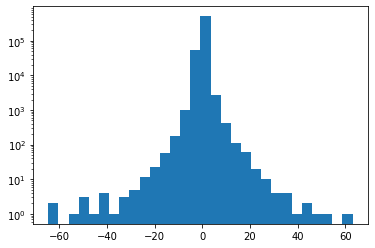

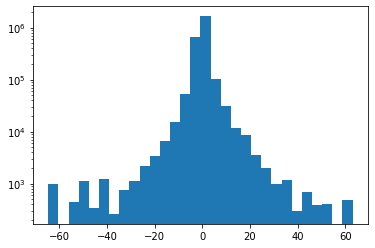

In [26]:
### Oversampling based on the magnitude of the label (y_data) ###

#x_data = x_train#[:10000]
#y_data = y_train#[:10000]

#plt.hist(y_data, bins = 30, log = True)
plt.hist(y_train, bins = 30, log = True)
plt.show()

#x_data, y_data = oversample(x_data = x_data, y_data = y_data, n = 2000000)
x_train, y_train = oversample(x_data = x_train, y_data = y_train, n = 2000000)
#print('x_data = ', x_data.shape)
#print('y_data = ', y_data.shape)

plt.hist(y_train, bins = 30, log = True)
plt.show()

In [27]:
### Building model ###
model = Sequential()
# NOTE - seems like LSTM only has GPU support when using tanh as the activation function!!!
model.add(LSTM(units = 30, input_shape = x_train.shape[1:], activation = 'tanh', return_sequences = False))
model.add(Dropout(rate = 0.5))
#model.add(LSTM(units = 15, activation = 'tanh', return_sequences = False))
model.add(Dense(units = 8, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 1, activation = 'linear'))

In [28]:
### Building model ###
model = Sequential()

model.add(CuDNNLSTM(units = 64, input_shape = x_train.shape[1:], return_sequences = True))
###model.add(LSTM(units = 64, input_shape = x_train.shape[1:], return_sequences = True))
#model.add(Dropout(rate = 0.3))
#model.add(BatchNormalization())

#model.add(CuDNNLSTM(units = 128, return_sequences = True))
#model.add(Dropout(rate = 0.3))
#model.add(BatchNormalization())

model.add(CuDNNLSTM(units = 8, return_sequences = False))
###model.add(LSTM(units = 8, return_sequences = False))
#model.add(Dropout(rate = 0.3))
#model.add(BatchNormalization())

#model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
#model.add(Dropout(rate = 0.5))

model.add(Dense(units = 1, activation = 'linear'))

In [29]:
### Defining optimization parameters ###
lr = 0.01
decay = 1e-3 # decay = 1e-5

opt = Adam(lr = lr, decay = decay)

#def mean_pred(y_true, y_pred):
#    return int(tf.make_ndarray(y_true) > tf.make_ndarray(y_pred))

model.compile(optimizer = opt, loss = 'mse')#, metrics = ['mse',)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 50, 64)            17408     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 8)                 2368      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 19,937
Trainable params: 19,937
Non-trainable params: 0
_________________________________________________________________


In [30]:
c### Train the model ###
batch_size = 2048 # 256
num_epochs = 3

#NAME = f"{history_size}-SEQ-{target_size}-PRED-{int(time.time())}"
#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

#filepath = "RNN_Final-{epoch:02d}-{val_acc:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
#checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10,20')

#tf.summary.trace_on(profiler = True)

history = model.fit(x = x_train, 
                    y = y_train,
                    epochs = num_epochs,
                    batch_size = batch_size,
                    validation_data = (x_val, y_val),
                    callbacks = [tensorboard_callback])

#tf.summary.trace_export(name = 'my_profiler', profiler_outdir = log_dir)

#model.compile(optimizer='sgd',
#          loss='binary_crossentropy',
#          metrics=['accuracy', mean_pred])
    
    


Epoch 1/3
1255/1255 [==============================] - 18s 14ms/step - loss: 6.6837 - val_loss: 1.4815
Epoch 2/3
1255/1255 [==============================] - 17s 13ms/step - loss: 3.9902 - val_loss: 1.5665
Epoch 3/3
1255/1255 [==============================] - 17s 13ms/step - loss: 3.5595 - val_loss: 1.5671


In [31]:
# Plot one example
def plot(x, y, pred = None):
    
    plt.plot(list(range(len(x))), x, '-bo', label = 'History')
    plt.plot(len(x), y, 'gx', label = 'True value')
    
    if pred:
        plt.plot(len(x), pred, 'rx', label = 'Prediction')
    
    plt.xlabel('Time steps')
    plt.legend()
    plt.show()
    

    return

# Plot multiple examples
def plot_multiple(x_data, y_data, model, n = 5):
    
    rand_indexes = [random.randint(0, len(x_data)) for x in range(n)]
    if model:
        preds = [model.predict(x_data[rand_index:rand_index+1]) for rand_index in rand_indexes]
    
    for i, rand_index in enumerate(rand_indexes):
        if model:
            plot(x_data[rand_index, :, 0], y_data[rand_index], preds[i])
        else:
            plot(x_data[rand_index, :, 0], y_data[rand_index])
    
    return

#plot(x_train[0, :, 0], y_train[0])
#plot(x_train[1, :, 0], y_train[1])

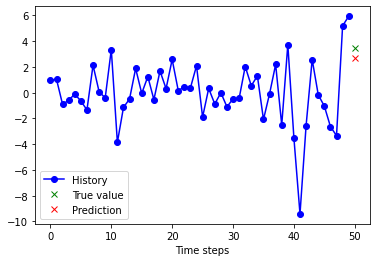

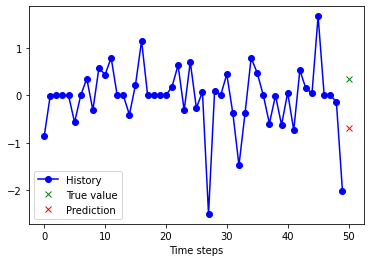

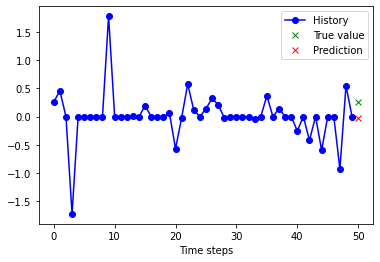

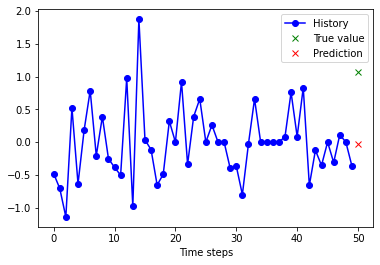

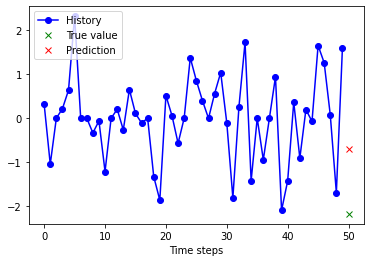

In [32]:
# Plotting the training data
plot_multiple(x_train, y_train, model = model)

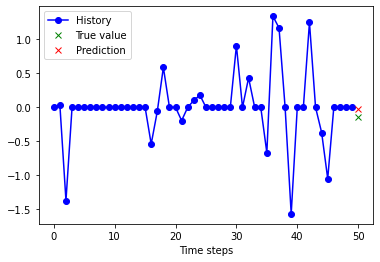

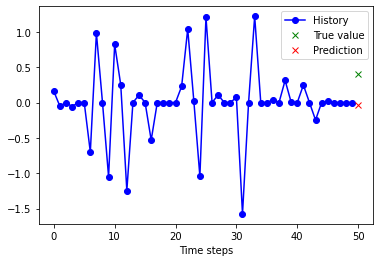

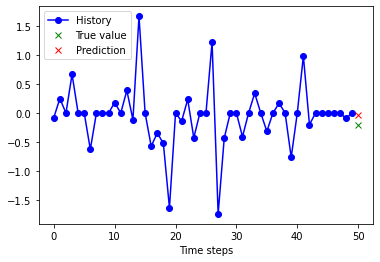

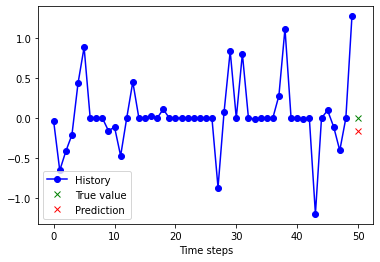

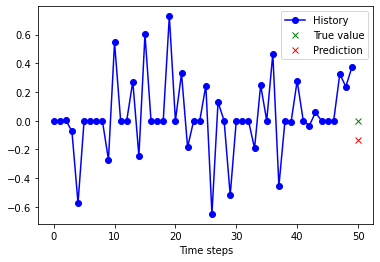

In [33]:
# Plotting the test data
plot_multiple(x_test, y_test, model = model)

In [34]:
### Evaluating the model ###
def evaluate_model(model, x_data, y_data, threshold = 0.1):
    #x_data = x_data[:150000]
    #y_data = y_data[:150000]
    preds = model.predict(x_data)
    
    evaluation_data = np.concatenate((x_data[:, -1, 0].reshape(-1, 1), 
                                      y_data.reshape(-1, 1), 
                                      preds), axis = 1)

    df = pd.DataFrame(data = evaluation_data, columns = ['x_last', 'y', 'pred'])
    #accuracyprint(df.head())
    df['y_action'] = df['y'].apply(lambda x: 'Buy' if x > threshold else ('Sell' if x < -threshold else 'Passive'))
    df['pred_action'] = df['pred'].apply(lambda x: 'Buy' if x > threshold else ('Sell' if x < -threshold else 'Passive'))

    df['accurate'] = df.apply(lambda x: 1 if x['y_action'] == x['pred_action'] else 0, axis = 1)
    
    accuracy = df['accurate'].sum() / len(df.index)
    #print('accuracy = ', accuracy, len(df.index))
    
    return accuracy, df

In [35]:
### Evaluating the model ###
train_accuracy, df_evaluation_train = evaluate_model(model, x_data = x_train, y_data = y_train)
print('train_accuracy = ', train_accuracy)

test_accuracy, df_evaluation_test = evaluate_model(model, x_data = x_test, y_data = y_test)
print('test_accuracy = ', test_accuracy)

train_accuracy =  0.44529608888989186
test_accuracy =  0.5805278674715709


In [36]:
### Evaluating the model using only Buy/Sell ###
def evaluate_model_binary(model, x_data, y_data):
    #x_data = x_data[:150]
    #y_data = y_data[:150]
    preds = model.predict(x_data)
    
    evaluation_data = np.concatenate((x_data[:, -1, 0].reshape(-1, 1), 
                                      y_data.reshape(-1, 1), 
                                      preds), axis = 1)

    df = pd.DataFrame(data = evaluation_data, columns = ['x_last', 'y', 'pred'])
    df['y_action'] = df['y'].apply(lambda x: 'Buy' if x > 0 else 'Sell')
    df['pred_action'] = df['pred'].apply(lambda x: 'Buy' if x > 0 else 'Sell')

    df['accurate'] = df.apply(lambda x: 1 if x['y_action'] == x['pred_action'] else 0, axis = 1)
    #print(df.head())
    accuracy = df['accurate'].sum() / len(df.index)
    #print('accuracy = ', accuracy, len(df.index))
    
    return accuracy, df

train_accuracy, df_evaluation_train = evaluate_model_binary(model, x_data = x_train, y_data = y_train)

In [37]:
### Evaluating the model using only Buy/Sell ###
train_accuracy, df_evaluation_train = evaluate_model_binary(model, x_data = x_train, y_data = y_train)
print('train_accuracy = ', train_accuracy)

test_accuracy, df_evaluation_test = evaluate_model_binary(model, x_data = x_test, y_data = y_test)
print('test_accuracy = ', test_accuracy)

train_accuracy =  0.5816065809895062
test_accuracy =  0.32230801628527306


In [38]:
tf.math.confusion_matrix([1, 2, 4], [2, 2, 4])
df_evaluation_train['y_action_int'] = df_evaluation_train['y_action'].apply(lambda x: 0 if x == 'Buy' else (1 if x == 'Sell' else 2))
df_evaluation_train['pred_action_int'] = df_evaluation_train['pred_action'].apply(lambda x: 0 if x == 'Buy' else (1 if x == 'Sell' else 2))
print(df_evaluation_train.head())
tf.math.confusion_matrix(df_evaluation_train['y_action_int'], df_evaluation_train['pred_action_int'])

     x_last         y      pred y_action pred_action  accurate  y_action_int  \
0  0.000512  0.000512 -0.027563      Buy        Sell         0             0   
1  0.463904  1.574615 -0.016251      Buy        Sell         0             0   
2 -0.083103 -0.000407 -0.032646     Sell        Sell         1             1   
3 -0.000476  0.311532 -0.034838      Buy        Sell         0             0   
4 -0.483905 -0.000640  0.026310     Sell         Buy         0             1   

   pred_action_int  
0                1  
1                1  
2                1  
3                1  
4                0  


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[521094, 837891],
       [237460, 973746]], dtype=int32)>